In [1]:
from proxy_methods_final import *
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import ttest_rel


/Users/alex_1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# set global plotting format
plt.style.use('seaborn-v0_8-bright')
plt.style.use('seaborn-v0_8-darkgrid')

# Load data
---

In [3]:
#Prices data
#-----------------------------------------
prices_data = pd.read_csv('data/reshaped_data.csv')
prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)
prices_data = prices_data.set_index('Date')

#Index data
#-----------------------------------------
index_data = pd.read_csv('ITRAXX-Europe Timeseries 20241127.csv') #To be used for b0
index_data.rename(columns={'AsOf':'Date'}, inplace=True)
try:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d-%b-%y')
except Exception as e:
    index_data['Date'] = pd.to_datetime(index_data['Date'], format='%d/%b/%y')
index_data = index_data.sort_values(by='Date', ascending=True)
#Metadata
#-----------------------------------------
metadata = pd.read_csv('data/metadata.csv')

#Community detection
#-----------------------------------------
correlation_matrix,T,N,company_names = create_correlation_matrix('data/eur_data_standardized_returns.csv')
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_39259/1307506813.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  prices_data['Date'] = pd.to_datetime(prices_data['Date'], infer_datetime_format=True)


# Generate proxies
---

In [4]:
# ticker = "AF" #Defined for the purposes of getting the liquid bucket (EVEN THOUGH WE USE THE INDEX)
# date = '2015-12-30'
# liquid_bucket = get_bucket(metadata, company_communities,ticker)[0]
# metadata_with_proxies = calculate_proxies_and_add_to_metadata(metadata, company_communities, prices_data, index_data, liquid_bucket, date)
# # metadata_with_proxies.to_csv('data/metadata_with_proxies.csv', index=False)

In [5]:
#Get matching dates in price data and index data
#-----------------------------------------
price_dates = prices_data.index.tolist()

#Extract date portion of the datetime object in the price data
index_dates = index_data['Date'].tolist()

matching_dates = [date for date in price_dates if date in index_dates]

In [6]:
# tickers = prices_data.columns.to_list() #First 10 tickers

# #ALEX DATES
# #-----------
# #dates = matching_dates[0:839]

# # #CALVIN DATES
# # dates = matching_dates[839:1678] 

# # #VINAYS DATES
# dates = matching_dates[1678:1683] 

# proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)
# proxy_time_series_df.to_csv('data/proxy_time_series_vinay_test.csv', index=False)

In [7]:
# #Return rows with Nan values
# proxy_time_series_df[proxy_time_series_df.isnull().any(axis=1)]

In [8]:
# #TROUBLESHOOTING
# #-----------------------------------------
# tickers = [prices_data.columns.to_list()[0]] #First ticker
# dates = matching_dates[0:1] #1 date
# # CALVIN: Changed calculate_proxy_time_series to use get_bucket to obtain bucket of respective ticker
# # define liquid bucket 
# # liquid_bucket = {
# #         'Sector': 'Financials',   
# #         'Country': 'United Kingdom',
# #         'Rating': 10
# #     }


# proxy_time_series_df = calculate_proxy_time_series(tickers, metadata, company_communities, prices_data, index_data, dates)
# proxy_time_series_df
# #-----------------------------------------

In [9]:
# proxy_time_series_df

# Normal CSRA vs Community CSRA
---

In [10]:
#First 839 days (alex)
proxy_time_series_df_alex = pd.read_csv('data/proxy_time_series_alex.csv')

#Vinay
proxy_time_series_df_vinay1 = pd.read_csv('data/proxy_time_series_vinay_1.csv')
proxy_time_series_df_vinay2 = pd.read_csv('data/proxy_time_series_vinay_2.csv')

In [11]:
proxy_time_series_concat = pd.concat([proxy_time_series_df_alex, proxy_time_series_df_vinay1, proxy_time_series_df_vinay2])

In [12]:
#Get index of max spread
acual_spreads = proxy_time_series_concat['Actual_Spread']

max_spread = np.max(acual_spreads)

max_spread_index = acual_spreads.idxmax()
max_spread_index

65832

In [13]:
#Get row with max spread
proxy_time_series_concat.iloc[max_spread_index]

Ticker                                CMZB
Date                            2012-03-13
Actual_Spread                   214.333333
Proxy_Intersection              187.779038
Proxy_Intersection_Community     67.914488
Proxy_CSRA                      387.662132
Proxy_CSRA_Community             329.98216
Name: 65832, dtype: object

In [14]:
#Remove row with NSINO Ticker (biggest spread)
proxy_time_series_concat_filtered = proxy_time_series_concat[proxy_time_series_concat['Ticker'] != 'NSINO']

In [15]:
dates = proxy_time_series_concat_filtered['Date'].unique().tolist()
len(dates)

1676

In [16]:
rmse_intersection_normal_list, rmse_intersection_communities_list, rmse_csra_normal_list, rmse_csra_communities_list = calculate_rmse_curves(proxy_time_series_concat_filtered, dates)

/Users/alex_1/Documents/GitHub/ATCF/proxy_methods_final.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_time_series_df['Date'] = pd.to_datetime(proxy_time_series_df['Date'])


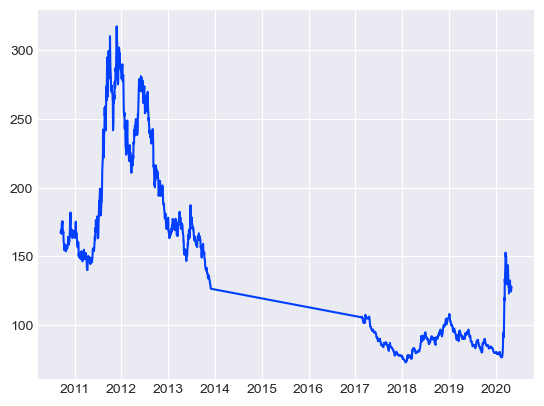

In [17]:
#Plot mean of actual spreads for each date
actual_spreads = proxy_time_series_concat_filtered['Actual_Spread'].groupby(proxy_time_series_concat_filtered['Date']).mean()
plt.plot(actual_spreads)

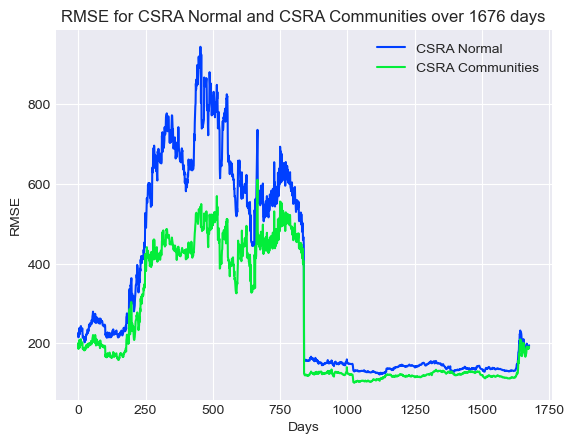

In [18]:
plot_rmse_curves(rmse_csra_normal_list, rmse_csra_communities_list, dates ,method='CSRA')

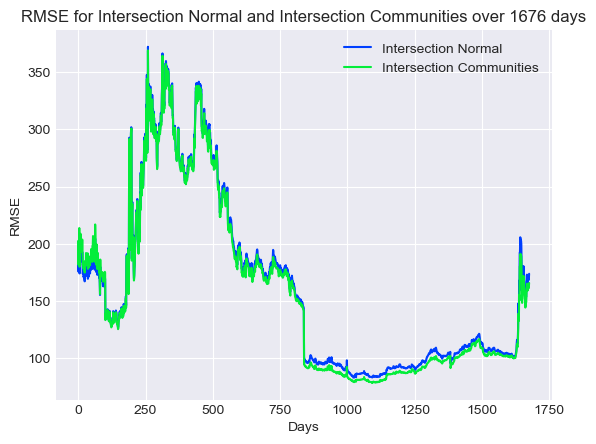

In [19]:
plot_rmse_curves(rmse_intersection_normal_list, rmse_intersection_communities_list, dates, method='Intersection')

In [24]:
calculate_percentage_better(rmse_csra_normal_list, rmse_csra_communities_list, method='CSRA')

Number of days where RMSE for normal CSRA method > RMSE for community CSRA method : 1676
Percentage of days where CSRA Communities method is better: 100.0%


In [23]:
calculate_percentage_better(rmse_intersection_normal_list, rmse_intersection_communities_list, method='Intersection')

Number of days where RMSE for normal Intersection method > RMSE for community Intersection method : 1574
Percentage of days where Intersection Communities method is better: 93.91408114558473%


In [22]:
paired_t_test(rmse_csra_normal_list, rmse_csra_communities_list)

Shapiro-Wilk Test Statistic: 0.7745685577392578, p-value: 4.049752561898721e-43
CHECKING FOR NORMALITY OF DIFFERENCES
--------------------------------------
The differences do not appear to be normally distributed (reject H0).
Cannot perform a paired t-test.
